In [1]:
print("Hello")

Hello


In [2]:
# ✅ Step 1: Install required packages
!pip install -q tensorflow tensorflow-datasets einops


In [3]:
# ✅ Step 2: Import necessary libraries
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from einops import rearrange


In [4]:
# ✅ Step 3: Load the Oxford Pets dataset (with segmentation masks)
def normalize_img(input_image, input_mask):
    input_image = tf.image.resize(input_image, (128, 128)) / 255.0
    input_mask = tf.image.resize(input_mask, (128, 128))
    input_mask = tf.squeeze(input_mask, axis=-1)
    input_mask = tf.cast(input_mask, tf.int32)
    return input_image, input_mask

def load_dataset(batch_size=32):
    dataset, info = tfds.load('oxford_iiit_pet', with_info=True)
    train = dataset['train'].map(lambda x: normalize_img(x['image'], x['segmentation_mask']))
    test = dataset['test'].map(lambda x: normalize_img(x['image'], x['segmentation_mask']))

    train = train.cache().shuffle(1000).batch(batch_size).repeat()
    test = test.batch(batch_size)
    return train, test, info

train_dataset, test_dataset, dataset_info = load_dataset()


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.ZMJ7KM_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.ZMJ7KM_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


Pixel-wise Accuracy: 82.39%


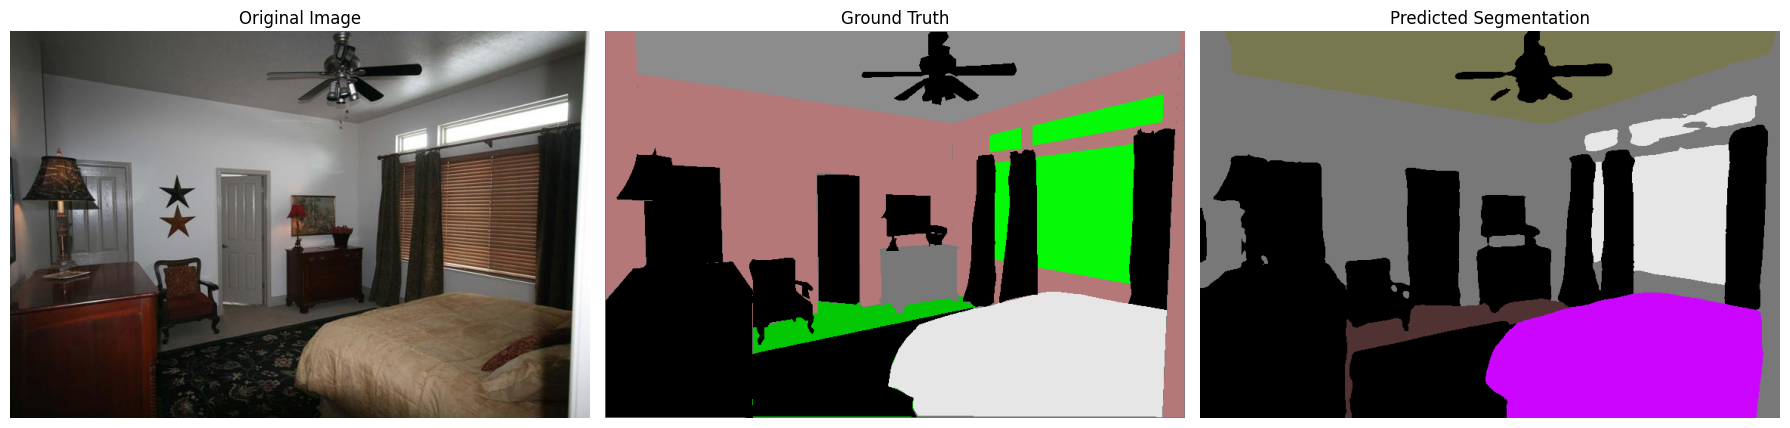

In [9]:
# ✅ Step 1: Install required packages
!pip install transformers datasets torchvision matplotlib -q

# ✅ Step 2: Import libraries
import torch
from transformers import AutoImageProcessor, AutoModelForSemanticSegmentation
from datasets import load_dataset
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
os.environ["HF_ALLOW_CODE_EXECUTION"] = "1"

# ✅ Step 3: Load the ADE20K dataset (small subset)
dataset = load_dataset("scene_parse_150", split="validation[:1]")  # 1 sample for demo

# Get image and ground truth segmentation mask
image = dataset[0]["image"]
ground_truth = np.array(dataset[0]["annotation"])

# ✅ Step 4: Load processor and model
checkpoint = "nvidia/segformer-b5-finetuned-ade-640-640"
processor = AutoImageProcessor.from_pretrained(checkpoint)
model = AutoModelForSemanticSegmentation.from_pretrained(checkpoint)

# ✅ Step 5: Preprocess input image
inputs = processor(images=image, return_tensors="pt")

# ✅ Step 6: Forward pass to get segmentation output
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits  # shape: (1, num_classes, H, W)

# Upsample to original image size
upsampled_logits = torch.nn.functional.interpolate(
    logits,
    size=ground_truth.shape,
    mode="bilinear",
    align_corners=False
)

# Get predicted class per pixel
predicted = upsampled_logits.argmax(dim=1)[0].cpu().numpy()

# ✅ Step 7: Calculate Pixel-wise Accuracy
correct = (predicted == ground_truth).sum()
total = ground_truth.size
accuracy = (correct / total )* 100
print(f"Pixel-wise Accuracy: {accuracy:.2f}%")

# ✅ Step 8: Visualize input image, ground truth, and prediction
def decode_segmentation(mask):
    ade_palette = np.array([
        [120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50], [4, 200, 3],
        [120, 120, 80], [140, 140, 140], [204, 5, 255], [230, 230, 230], [4, 250, 7],
        # Pad up to 150 classes
    ] + [[0, 0, 0]] * (150 - 10), dtype=np.uint8)

    color_seg = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for label in np.unique(mask):
        color_seg[mask == label] = ade_palette[label]
    return color_seg

decoded_pred = Image.fromarray(decode_segmentation(predicted))
decoded_gt = Image.fromarray(decode_segmentation(ground_truth))

# ✅ Step 9: Plot all images
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(decoded_gt)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Predicted Segmentation")
plt.imshow(decoded_pred)
plt.axis("off")

plt.tight_layout()
plt.show()
